In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from src.components.cdvi import load_cdvi_for_bml
from src.utils.eval import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid, normalize_vals_on_grid)
from src.utils.train_val_bml import (BetterBMLTrainer,
                                     AlternatingBMLTrainer,
                                     TestAlternatingBMLTrainer)
from src.utils.visualize import (visualize_cdvi_for_bml,
                                 visualize_cdvi_for_bml_test,
                                 visualize_vals_on_grid_2d)

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
device = torch.device("cpu") 
print(device)

cpu


In [3]:
dir = "../models/test" 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="config")

    cdvi, optimizer, train_loader, val_loader = load_cdvi_for_bml(cfg, device)

    cdvi_path = f"{dir}/cdvi.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(cdvi_path):
        cdvi_state_dict = torch.load(cdvi_path, map_location=torch.device("cpu"), weights_only=True)
        cdvi.load_state_dict(cdvi_state_dict)
        print(f"loaded cdvi from {cdvi_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'), weights_only=True)
        optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 261131.92it/s]


In [5]:
wandb_logging = False

if wandb_logging:
    wandb.init(project="dvi-bml-test")

In [6]:
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]

scheduler = None #ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=500)

# trainer = BetterBMLTrainer(
#     device=device,
#     cdvi=cdvi,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     wandb_logging=wandb_logging
# )

trainer = AlternatingBMLTrainer(
    device=device,
    cdvi=cdvi,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    wandb_logging=wandb_logging
)

# trainer = TestAlternatingBMLTrainer(
#     device=device,
#     cdvi=cdvi,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     wandb_logging=wandb_logging
# )

In [ ]:
num_epochs = 1000

losses = trainer.train_and_validate(
    num_epochs=num_epochs,
    max_clip_norm=cfg.training.max_clip_norm,
    alpha=cfg.training.alpha,
    validate=False
)

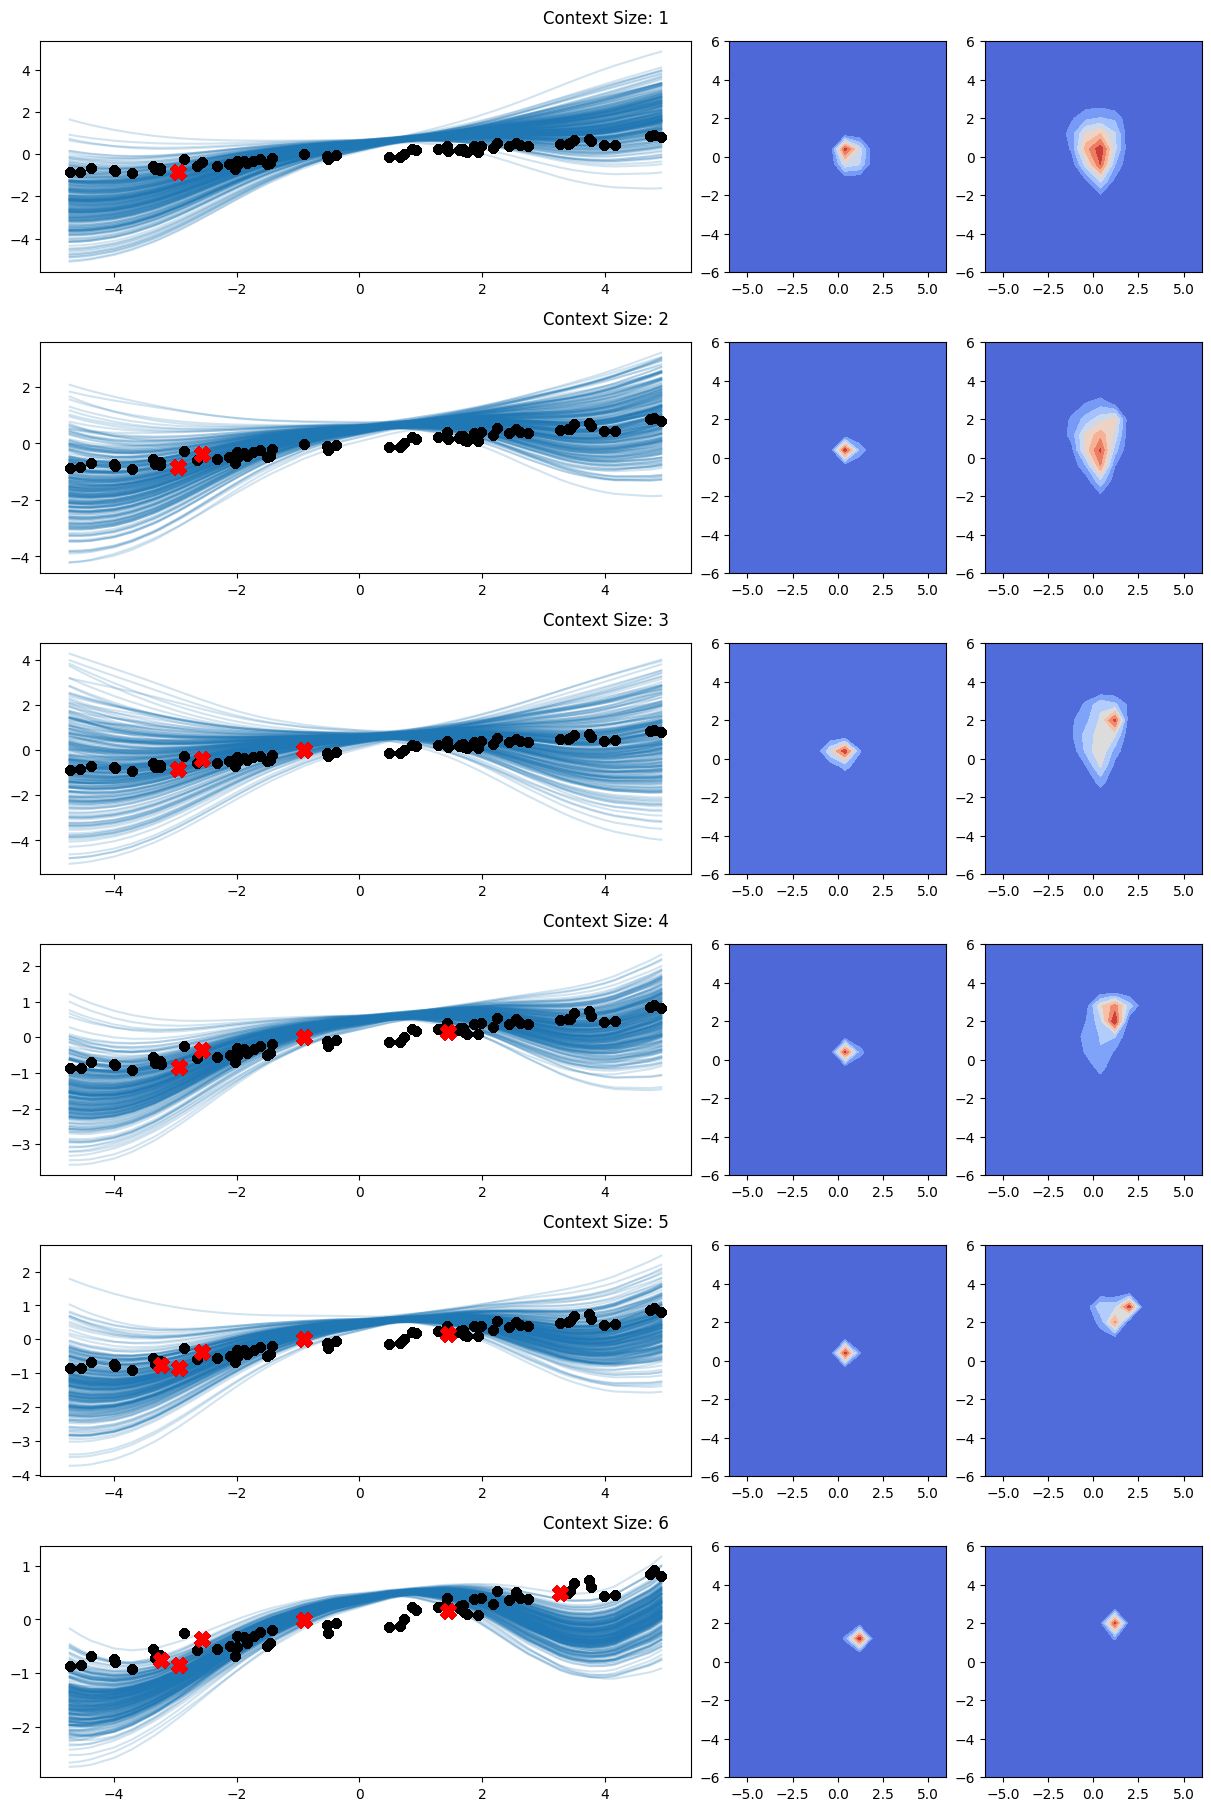

In [13]:
max_context_size = 6
num_samples = 256
gen_dataloader = DataLoader(val_loader.dataset, 1, True)

intervals = [(-6, 6), (-6, 6)]
num = 16

targets, samples = visualize_cdvi_for_bml_test(
    device=device,
    cdvi=cdvi,
    dataloader=gen_dataloader,
    config=cfg,
    num_samples=num_samples,
    max_context_size=max_context_size,
    intervals=intervals,
    num=num
)

jsd: 0.35311787017712515 bd: 0.5710322039587353


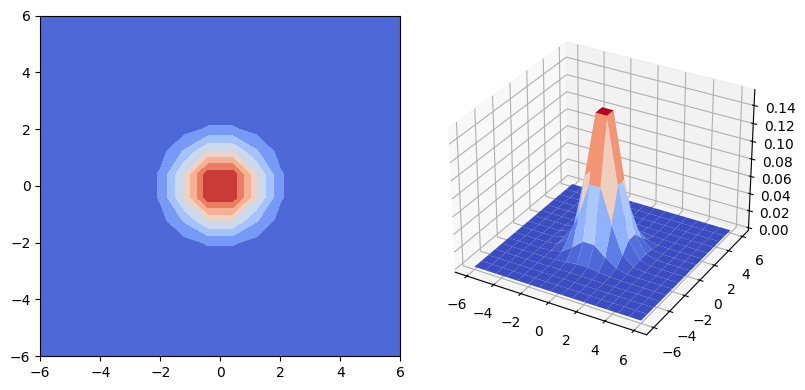

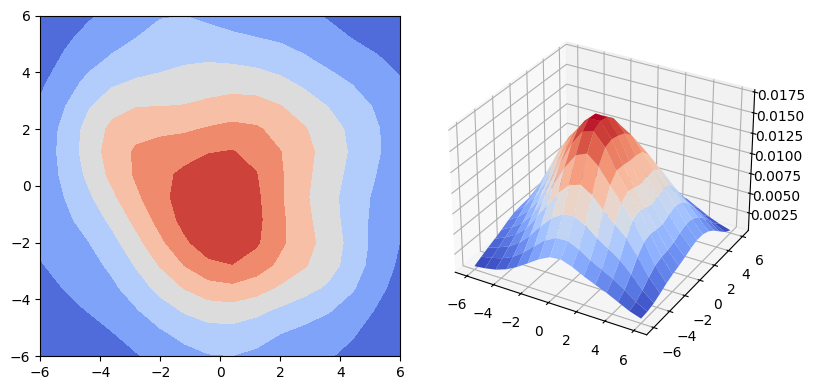

jsd: 0.3795199500927974 bd: 0.6345264051057969


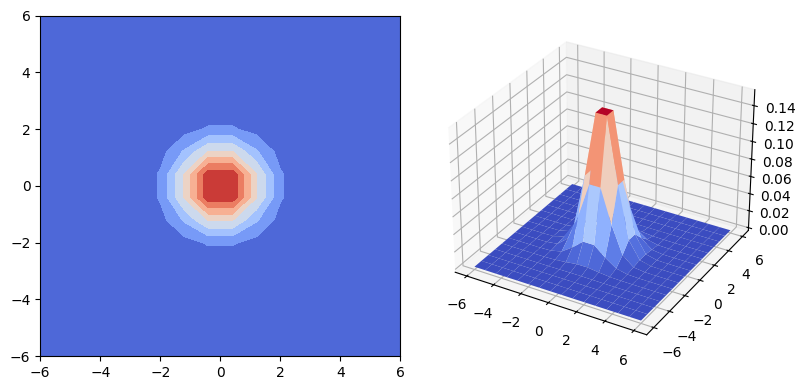

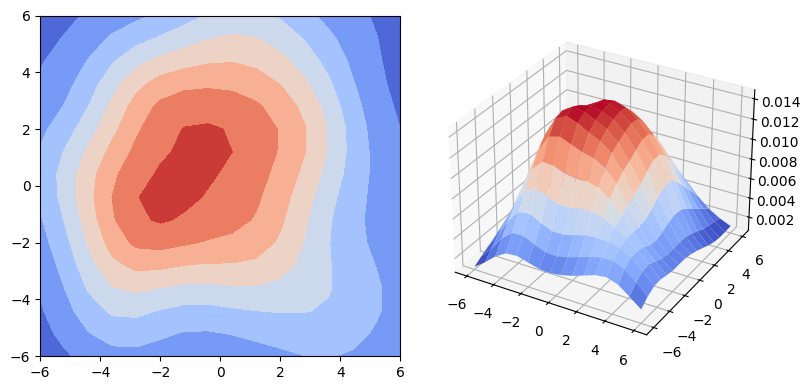

jsd: 0.36077495822624195 bd: 0.5886838604285656


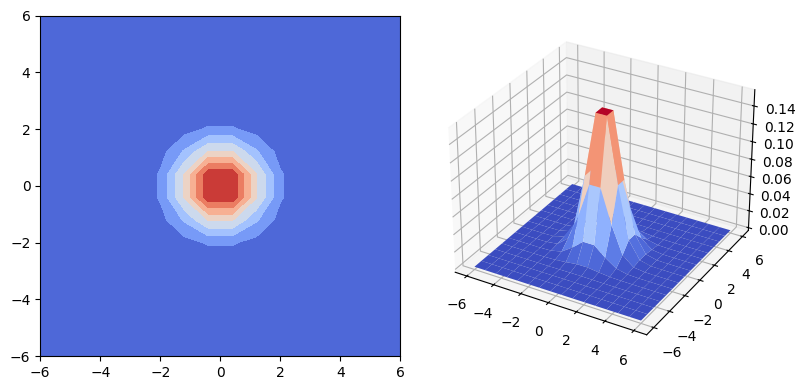

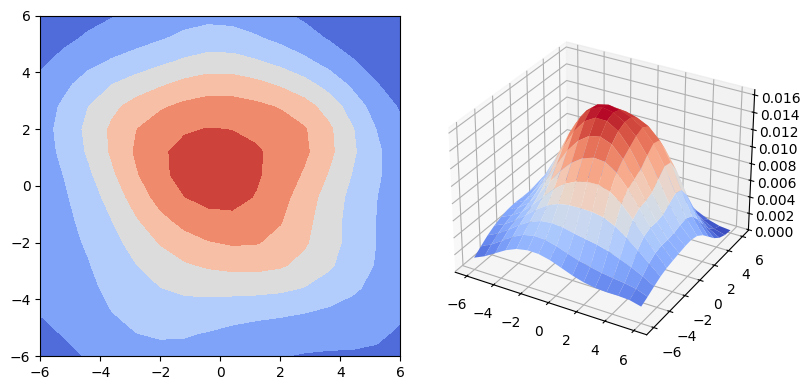

jsd: 0.3644638043718502 bd: 0.5971094734455502


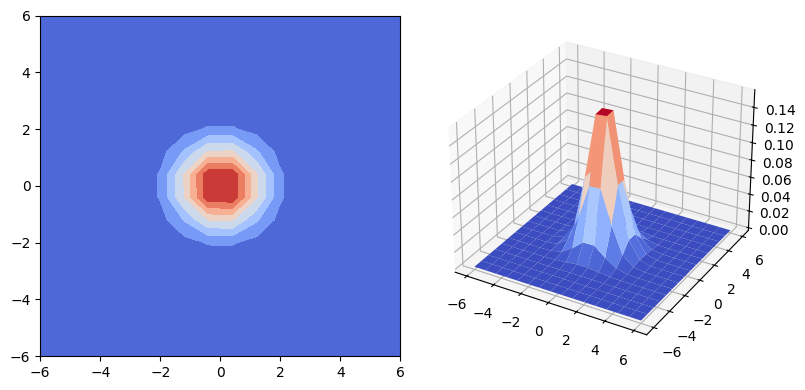

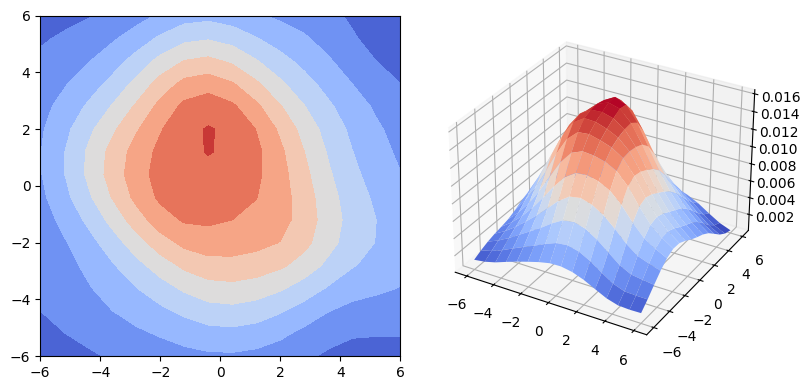

jsd: 0.37013983482911333 bd: 0.6123978881356839


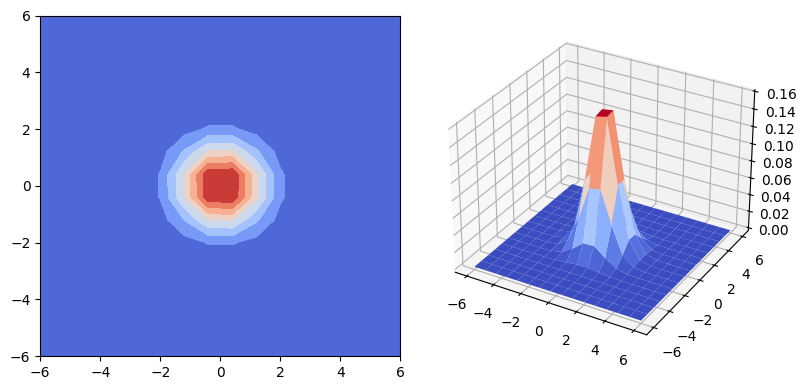

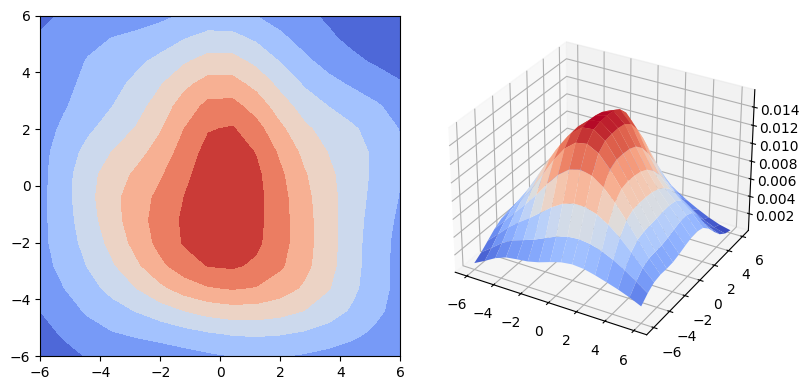

jsd: 0.3792970146951506 bd: 0.6348444346123115


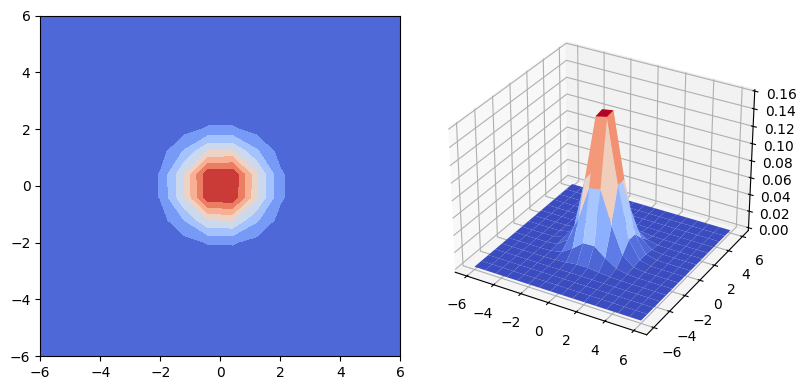

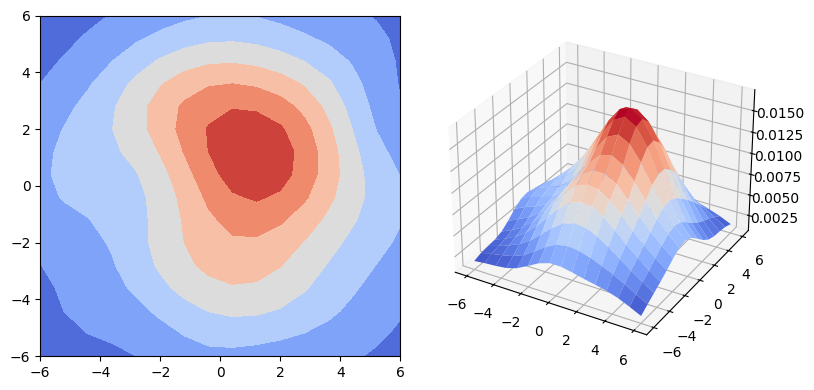

In [ ]:
intervals = [(-6, 6), (-6, 6)]
num = 16
grid = create_grid(intervals, num)

for i in range(len(targets)):
    target_vals = eval_dist_on_grid(grid, targets[i], device=device)
    target_vals = normalize_vals_on_grid(target_vals, intervals, num)

    dvi_vals = eval_kde_on_grid(grid, samples[i])
    dvi_vals = normalize_vals_on_grid(dvi_vals, intervals, num)

    #dvi_vals_2 = eval_hist_on_grid(samples[i], intervals, num)

    jsd = compute_jsd(target_vals, dvi_vals, intervals, num)
    bd = compute_bd(target_vals, dvi_vals, intervals, num)

    print(f"jsd: {jsd}", f"bd: {bd}")

    visualize_vals_on_grid_2d(grid, target_vals)
    visualize_vals_on_grid_2d(grid, dvi_vals)
    #visualize_vals_on_grid_2d(grid, dvi_vals_2)

In [ ]:
torch.save(cdvi.state_dict(), f"{dir}/cdvi_finetuned.pth")